<a href="https://colab.research.google.com/github/tamburins/ESAA-2022-/blob/main/ESAA_12_2(342_375).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 09 회귀 실습 -자전거 대여 수요 예측

- 변수소개:
> datetime(horly date + timestamp)

> season: 1=spring, 2=summer, 3=autumn, 4=winter

> holidaty 1=except weekend holidy, 0: not holiday

> workingday: 1=workday, 0=weekend & holiday

> weather : 1 sunny little cloudy, 2 = 안개, 안개흐림, 3= 가벼운 눈, 비 + 천둥, 4= 심한 눈, 비, 천둥, 번개

> temp: temperature

> attemp: 체감온도

> humidity: realtive humidity

> windspeed: windspeed

> casual: not booked users’ 대여횟수

> Registerd: registered users’ 대여횟수

> count: 대여횟수

#### 데이터 클렌징 및 가공


In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/bike_train.csv')
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [54]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [55]:
#change str to datetime
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

#get year month day time from datetime type
bike_df['year']=bike_df.datetime.apply(lambda x: x.year)
bike_df['month']=bike_df.datetime.apply(lambda x: x.month)
bike_df['day']=bike_df.datetime.apply(lambda x: x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [56]:
#delete datetime column
#delete casual n register
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)


In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#log값값 변환시시 nan등의의 이슈로로 log() 대신신 log1p를를 이용하여여 RMSLE 계산산
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred ) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런런의의 meansquare error > cal rmse
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# mse, rmse, rsmle
def evaluate_regr(y, pred):
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y, pred)
  # MAE calculated by mean absolute error
  mae_val = mean_absolute_error(y, pred)
  print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [58]:
# 다음과과 같은은 rmsle 구현은은 언더플로나나 오버플로로 오류를를 발생하기기 쉬움움
#def rmsle(y, pred):
  #msle = mean_squared_log_error(y, pred)
  #rmsle = np.sqrt(mse)
  #return rmsle
  

#### 로그변환, 피처인코딩과 모델 학습예측평가

In [59]:
#카테고리형형 회귀모델의의 원한인코딩딩
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state =0 )

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)


RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [60]:
def get_top_error_data(y_test, pred, n_tops = 5):
  #with dataframe's column, create for 실제대여횟수와와 예측값값 비교
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count']=np.round(pred)
  result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
  
  #예측값과과 실제값이이 가장장 큰큰 데이터터 순으로로 출력력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

# biggest top5 have big pred error

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


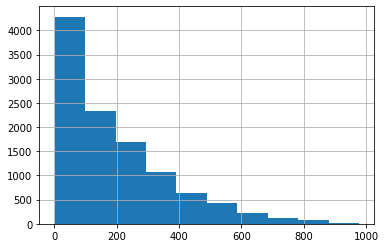

In [61]:
#check distribution of target
y_target.hist()

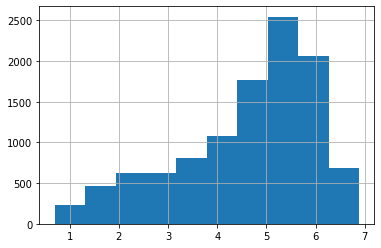

In [62]:
# not normal dist
# apply log1p
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [63]:
# train again n test
# apply log1p with count
y_target_log = np.log1p(y_target)

# y_target_log > train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, train_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

#테스트트 데이터터 세트의의 target을을 다시시 원래래 스케일로로 변환환
y_test_exp = np.expm1(y_test)

#예측값값 다시시 스케일일 변환환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)


RMSLE: 1.020, RMSE: 161.048, MAE: 107.654


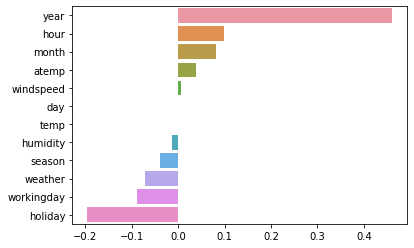

In [64]:
# decreasing rmsle, increasing rmse
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [65]:
#year's coef is big
# apply one hot encoding

#year month day hour > one-hot encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

In [66]:
#check predict ability
# create function get-model predict
#one hotencoding set > train test split

X_train, X_test,y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state = 0)

# get ability score when input model, train/test dataset
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__,'###')
  evaluate_regr(y_test, pred)
# end of func

# apply for each model
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=0)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)
  

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.591, RMSE: 97.991, MAE: 63.503
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


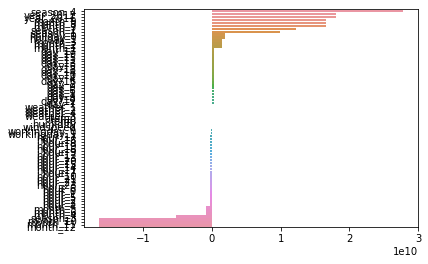

In [67]:
# get top25 features
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [68]:
# importance of way of encoding
# regresiion predict with regression tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#랜덤포레스트, GBM, XGBoost, lightgbm model별별 평가수행행
rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg =GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [ rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  #XGBOost can get error with dataframe, so transform it to ndarrya
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.383, MAE: 31.196
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.336, MAE: 32.737
[14:18:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE: 58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


better predict ability!

but can change result with dataset's type

### 10 회귀 실습 - 캐글 주택 가격 : 고급 회귀 기법

#### 데이터 사전 처리(Preprocessing)


In [69]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [70]:
print('shape of dataset: ',house_df.shape)
print('\n type of all features: ', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과과 그건수수: \n', isnull_series[isnull_series >0].sort_values(ascending=False))

shape of dataset:  (1460, 81)

 type of all features:  object     43
int64      35
float64     3
dtype: int64

Null 칼럼과과 그건수수: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


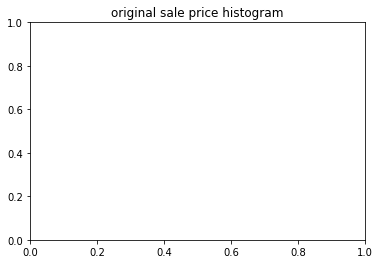

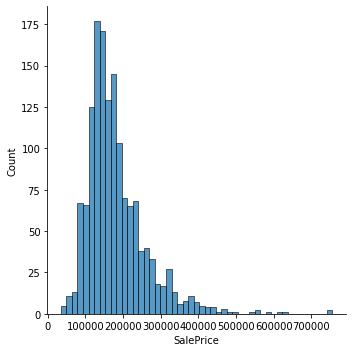

In [71]:
#null값이 너무 많은 피처 드롭
# 정규분포 확인
plt.title('original sale price histogram')
sns.displot(house_df['SalePrice'])


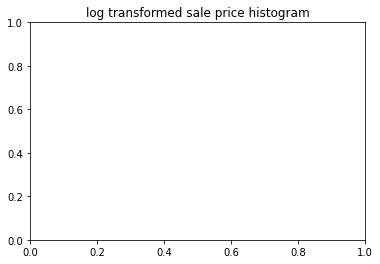

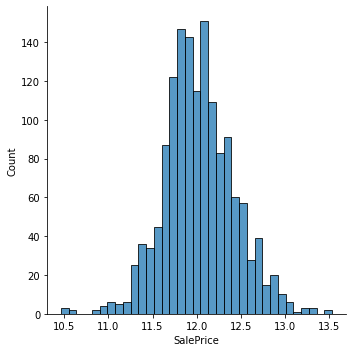

In [72]:
#정규분포가 아닌 결괏값을 정규분포로 변환하기 위해 로그변환 적용
plt.title('log transformed sale price histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.displot(log_SalePrice)
#정규분포임을 확인
# null 이 너무많은 피처 삭제

In [73]:
# saleprice log transform
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

#Null이 너무많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1,
              inplace=True)
#null column inplace mean
house_df.fillna(house_df.mean(), inplace=True)

#null값이있는 피처명과 타입 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 type: \n', house_df.dtypes[null_column_count.index])


## Null 피처의 type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [77]:
# 문자형 인코딩의 원핫인코딩 with get_dummies
print('before get_dummies,shape of datasets ', house_df.shape)
house_df_ohe=pd.get_dummies(house_df)
print('after get_dummies, shape of datasets', house_df_ohe.shape)

null_column_count= house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## null 피처의 타입 \n', house_df.dtypes[null_column_count.index])

before get_dummies,shape of datasets  (1460, 75)
after get_dummies, shape of datasets (1460, 271)
## null 피처의 타입 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


#### 선형 회귀모델 학습/예측/평가

예측값이 로그변환값이므로 로그변환된 rmse 측정, 이를 생성하는 함수 생성

In [78]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, 'log transformed RMSE:', np.round(rmse,3))

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses
  


In [79]:
# linear regression train predict evaluate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                    random_state=156)
#LinearRegression, Ridge, Lasso train, test, evaluate
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression log transformed RMSE: 0.132
Ridge log transformed RMSE: 0.128
Lasso log transformed RMSE: 0.176


[None, None, None]

In [80]:
# Lasso gets low ability,
# it has to tuning parameter
def get_top_bottom_coef(model, n=10):
  #with coef, Series 객체 생성, index is columnname
  coef = pd.Series(model.coef_, index=X_features.columns)

  #get + highest 10, -lowest 10 coef 
  coef_high = coef.sort_values(ascending = False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

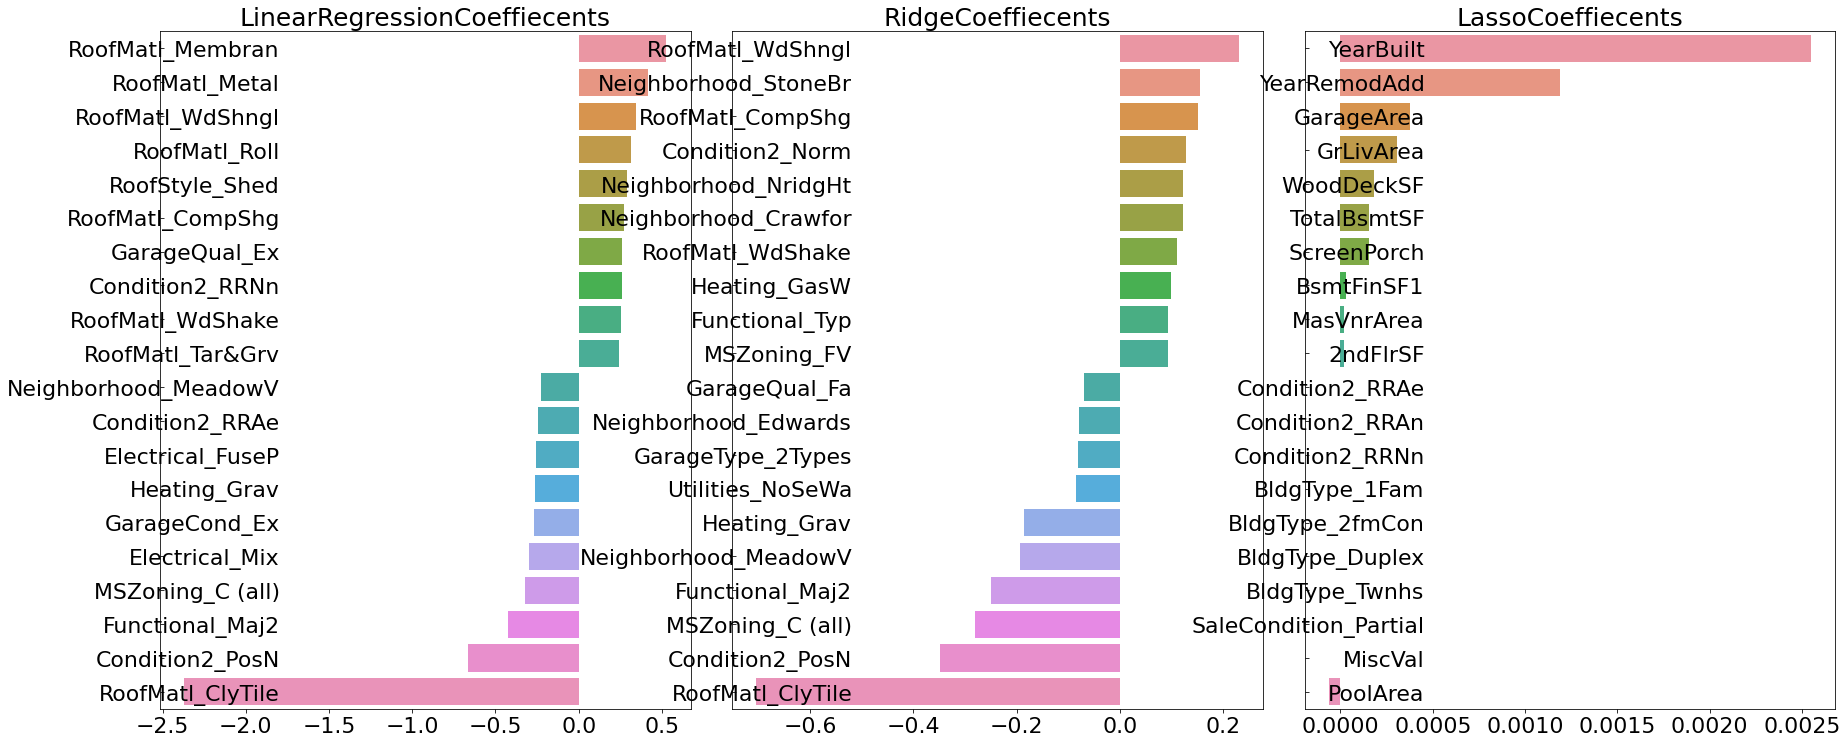

In [83]:

#with def, visualize coefs of model
def visualize_coefficient(models):
  #top 3 model's visualizing, create subplot with 3 columns
  fig, axs = plt.subplots(figsize = (24,10), nrows = 1, ncols=3)
  fig.tight_layout()
  #입력 인자로 받은 list 객체인 models에서 차례로 모델을 추출해 회귀계수 시각화
  for i_num, model in enumerate(models):
    #상위 10개, 하위 10개 회귀계수를 구하고 이를 판다스 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
    # ax subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick label위치와 폰트조정
    axs[i_num].set_title(model.__class__.__name__+'Coeffiecents',size=25)
    axs[i_num].tick_params(axis='y', direction = "in", pad=-120)
    for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

#앞 예제에서 ㅎㅏㄱ습한한 lr_reg, ridge_reg, lasso_reg 모델의의 회귀계수수 시각화화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [84]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

  for model in models:
    # no split, cross val score for all data. print avg rmse and cv rmse for each model
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                         scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} cv rMSE 값 리스트: {1}'.format(model.__class__.__name__,np.round(rmse_list, 3)))
    print('\n{0} cv 평균 rmse 값: {1}'.format(model.__class__.__name__,np.round(rmse_avg, 3)))
#앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg의 cv rmse 출력
models= [lr_reg, ridge_reg, lasso_reg]

get_avg_rmse_cv(models)


LinearRegression cv rMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]

LinearRegression cv 평균 rmse 값: 0.155

Ridge cv rMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]

Ridge cv 평균 rmse 값: 0.144

Lasso cv rMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]

Lasso cv 평균 rmse 값: 0.198


In [96]:
#5개의 폴드세트로 학습하고 평가해도 여전히 성능이 떨어져 alpha를 변화시키며 최적값을 도출하고자 함
from sklearn.model_selection import GridSearchCV
def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid = params,
                            scoring="neg_mean_squared_error", cv=5)
  grid_model.fit(X_features, y_target)
  rmse =np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 cv 시 최적평균 rmse값: {1}, best alpha: {2}'.format(model.__class__.__name__,
                                                             np.round(rmse,4), grid_model.best_params_))
ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

  # better ability with best alpha 

Ridge 5 cv 시 최적평균 rmse값: 0.1276, best alpha: {'alpha': 10}
Lasso 5 cv 시 최적평균 rmse값: 0.1251, best alpha: {'alpha': 0.001}


LinearRegression log transformed RMSE: 0.129
Ridge log transformed RMSE: 0.121
Lasso log transformed RMSE: 0.117


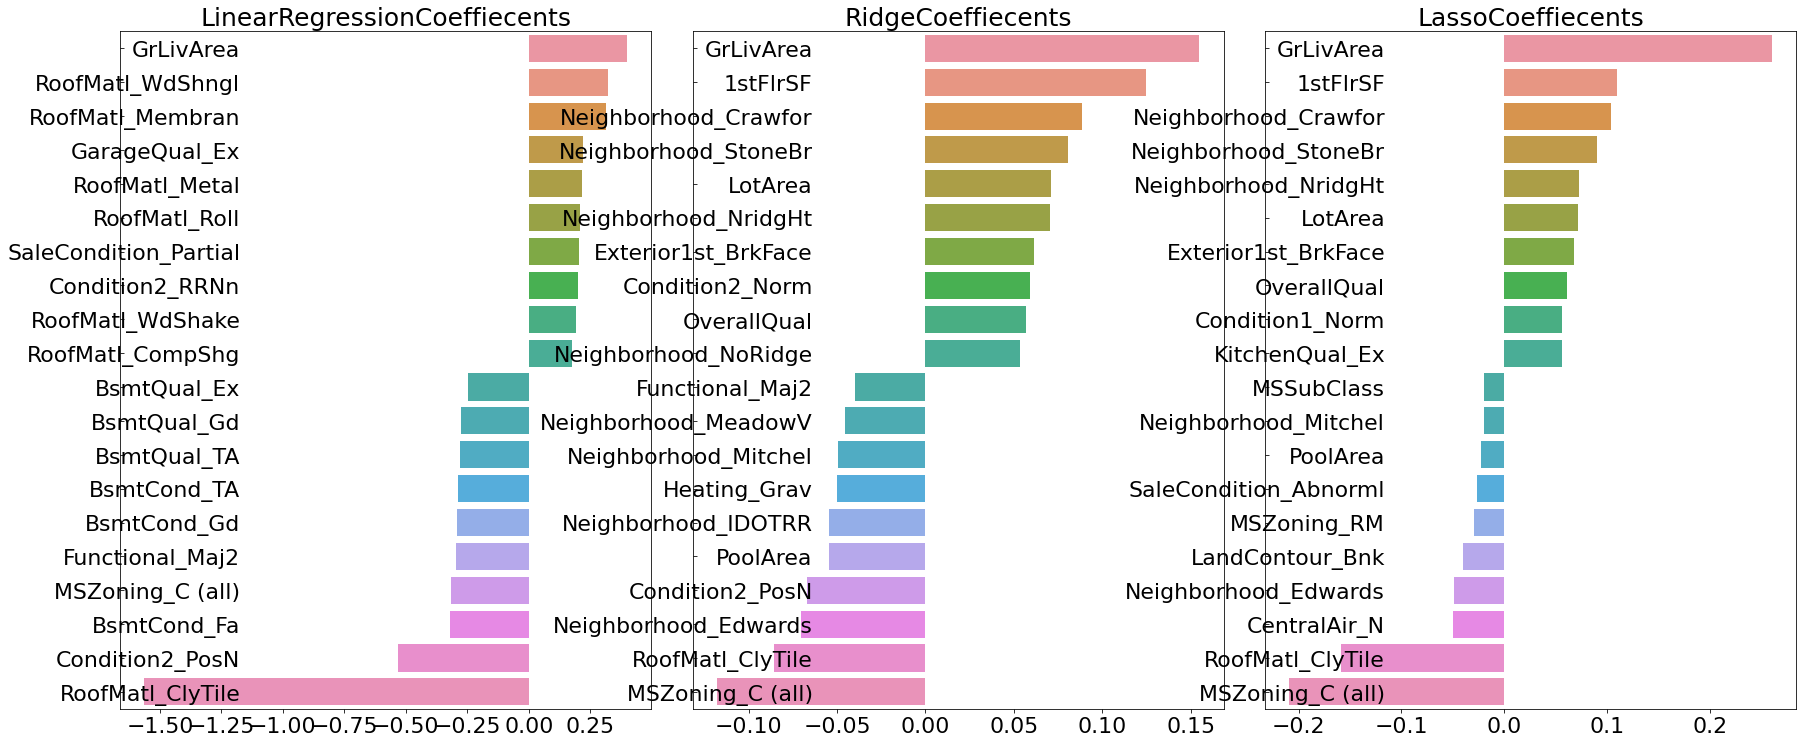

In [97]:
# with best alpha, train test predict evaluate
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# all models' rmse
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# all models' coeff visualize
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 알파 최적화 후라쏘와 릿지의 비슷한 회귀계수가 높으나 라쏘같은 경우 릿지에 비해 동일한 피처더라도 회귀 계수값이 상당히 높음

- 데이터의분포도를 확인하여 분포도의 왜곡된 정도를 알아보고자 함

- 사이킷런 skew()함수를 이용하여 왜곡정도 추출이 가능하며, 1이상의 값을 반환하는 피처만 추출해 왜곡정도를 완화하기 위해 로그변환을 적용

- 원핫인코딩된 피처는 카테고리성 피처로 왜곡정도를 따질 떄 제외해야함

In [98]:
from scipy.stats import skew

#not object, get float int features' column index
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# housedf에 칼럼인덱스를 []로 입력하면 해당하는 칼럼 데이터세트 변환. apply lambda로 skew 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))
# get more skew than 1
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])


PoolArea         14.339852
3SsnPorch         7.638944
LowQualFinSF      7.330902
MiscVal           5.036720
BsmtHalfBath      3.888823
ScreenPorch       3.118480
KitchenAbvGr      2.954603
BsmtFinSF2        2.446157
EnclosedPorch     2.062641
dtype: float64


In [99]:
# 로그변환하면서 어려워진 애들 다시 원핫인코딩 및 데이터 분리 
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test =train_test_split(X_features, y_target, test_size=0.2,
                                                   random_state = 156)

# 피처를 로그변환한 후 다시 최적 하이퍼ㅏ라미터와 rmse 출력
ridge_params = { 'alpha': [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001,0.005,0.008,0.03,0.05,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

# ridge의 최적 알파값이 변동
# 5폴드 교차검증의 평균 rmse값이 향상

Ridge 5 cv 시 최적평균 rmse값: 0.1275, best alpha: {'alpha': 10}
Lasso 5 cv 시 최적평균 rmse값: 0.1251, best alpha: {'alpha': 0.001}


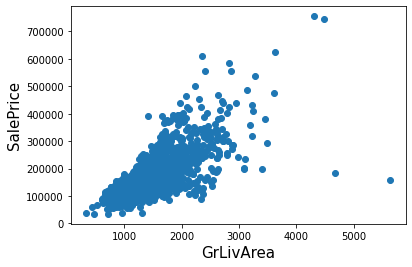

In [100]:
# 이상치 데이터 처리
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize = 15)
plt.show()

In [101]:
# 일반적으로 비례관계, 두개의 데이터가 관계에서 크게 어긋나므로 삭제
# grlivarea와 saleprice 모두 로그변환됐으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea']>np.log1p(4000)
cond2 = house_df_ohe['SalePrice']<np.log1p(500000)
outlier_index = house_df_ohe[cond1& cond2].index

print('이상치 레코드 index: ', outlier_index.values)
print('이상치 삭제전 house_df_ohe shape: ', house_df_ohe.shape)

#dataframe 의 인덱스를 이ㅛㅇ하여 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape', house_df_ohe.shape)

이상치 레코드 index:  [ 523 1298]
이상치 삭제전 house_df_ohe shape:  (1460, 271)
이상치 삭제 후 house_df_ohe shape (1458, 271)


In [102]:
#업데이트 된 애들을 기반으로 다시 최적화 수행 및 결과 출력
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test =train_test_split(X_features, y_target, test_size=0.2,
                                                   random_state = 156)

# 피처를 로그변환한 후 다시 최적 하이퍼ㅏ라미터와 rmse 출력
ridge_params = { 'alpha': [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001,0.005,0.008,0.03,0.05,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


Ridge 5 cv 시 최적평균 rmse값: 0.1125, best alpha: {'alpha': 8}
Lasso 5 cv 시 최적평균 rmse값: 0.1123, best alpha: {'alpha': 0.001}


In [103]:
#예측 수치의 큰 향상 및 최적 알파값의 변화, rmse 의 향상
# 이상치는 회귀에 중요한 영향을 미치는 피처 위주로 찾으며 완벽하게 데이터 선처리를 할 필요는 없으나 계속 최적화를 해야할 필요는있음


#### 회귀 트리 모델 학습/예측/평가


In [104]:
from xgboost import XGBRegressor
xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate = 0.05, colsample_bytree =0.5, subsaple=0.8 )
print_best_params(xgb_reg, xgb_params)

[14:26:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 cv 시 최적평균 rmse값: 0.1157, best alpha: {'n_estimators': 1000}


In [105]:
# same with lgbm
from lightgbm import LGBMRegressor
lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate = 0.05, num_leaves = 4,
                         subsample = 0.6, colsample_bytree = 0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)



LGBMRegressor 5 cv 시 최적평균 rmse값: 0.1161, best alpha: {'n_estimators': 1000}


#### 회귀 모델의 예측 결과 혼합을 통한 최종 예측

- 여러 모델이 있다면 여러 모델의 결과를 일정부분씩 수용하여 최종 회귀값으로 예측

- 최종 혼합 모델, 개별 모델의 rmse 값을 출력하는 get rmse pred 를 생성하고 예측값을 계산한 뒤 개별모델과 최종혼합모델의 rmse를 구함

In [107]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} models rmse: {1}'.format(key, rmse))

# train each model
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha= 0.001)
lasso_reg.fit(X_train, y_train)

#each model's predict
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# get final predict with mixture of models
pred = 0.4*ridge_pred + 0.6 * lasso_pred
preds= {'최종혼합': pred, 'Ridge': ridge_pred, 'Lasso':lasso_pred }

# fin mix model and each model's rmse 
get_rmse_pred(preds)

최종혼합 models rmse: 0.09966514052353523
Ridge models rmse: 0.10288980218833503
Lasso models rmse: 0.10001446974492119


In [108]:
xgb_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05,
                       colsample_bytree = 0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4,
                         subsample=0.6, colsample_bytree = 0.4, reg_lambda =10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종혼합':pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
get_rmse_pred(preds)


[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종혼합 models rmse: 0.09897715854093486
XGBM models rmse: 0.10075115846547565
LGBM models rmse: 0.1015065721553885


#### 스태킹 앙상블 모델을 통한 회귀예측

- 개별적인 기반 모델과 개별모델의 예측데이터를 학습데이터로 만들어 학습하는 최종 메타모델로 만드는 것으로 개별 기반모델의 예측데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처데이터 세트와 테스트용 피처데이터 세트를 만드는 것 

In [117]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정 nfolds > kfold 생성
  kf = KFold(n_splits = n_folds, shuffle=False)
  #추후 메타모델이 사용할 학습데이터 반환을 위해 넘파이배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model starts')
  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습데이터에서 기반모델이 학습/예측할 폴드데이터 세트 추출
    print('\t fold set: ', folder_counter, 'starts')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # inside fold set, train again with reorganinzing training data
    model.fit(X_tr, y_tr)
    # inside fold set reorganized data, predict n save data
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본테스트 데이터를 폴드세트 내 학습된 기반모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)
  #폴드세트 내에서 원본테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  #train_fold_pred는 최종메타모델이 사용하는 학습데이터, test_pred_mean은 테스트데이터
  return train_fold_pred, test_pred_mean

- 함수 내에서 개별 모델이 k폴드 세트로 설정된 폴드세트 내부에서 원본의 학습데이터를 다시 추출해 학습과 예측을 수행한 뒤 그 결과를 저장하고 이 저장된 데이터가 추후 메타모델의 학습 피처 데이터세트로 이용되며, 함수내에서 최종적으로 폴드세트 내부 학습데이터로 학습된 개별 모델이 인자로 입력된 원본 테스트 데이터를 예측한 뒤, 예측 결과를 평균해 테스트 데이터로 생서

In [118]:
# get_stacking_base_datasets는 넘파이 ndarray를 인자로 사용하므로 datframe을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

#각 개별 기반 모델이 생성한 학습/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train,lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)


Ridge model starts
	 fold set:  0 starts
	 fold set:  1 starts
	 fold set:  2 starts
	 fold set:  3 starts
	 fold set:  4 starts
Lasso model starts
	 fold set:  0 starts
	 fold set:  1 starts
	 fold set:  2 starts
	 fold set:  3 starts
	 fold set:  4 starts
XGBRegressor model starts
	 fold set:  0 starts
[14:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 fold set:  1 starts
[14:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 fold set:  2 starts
[14:31:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 fold set:  3 starts
[14:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 fold set:  4 starts
[14:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated i

In [119]:
#개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

#fin model apply lasso model
meta_model_lasso = Lasso(alpha=0.0005)

#개별 모델 예측값을 기반으로새롭게 만들어진 학습/테스트 데이터로 메타모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)

print('스태킹회귀모델의 최종 rmse :',rmse)

스태킹회귀모델의 최종 rmse : 0.09718244725274663
